# Enron Dataset POI Indentifier

## I. Project Overview
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, I will play detective, and put my new skills to use by building a person of interest (POI) identifier based on financial and email data made public as a result of the Enron scandal. To assist in my detective work, there is a combination of data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

In [1]:
#!/usr/bin/python

import sys
import pickle
import warnings
warnings.filterwarnings("ignore")
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ["poi", "salary", "bonus_salary_ratio", "fraction_from_poi", "fraction_to_poi", "deferral_payments", "total_payments", \
                     "loan_advances", "bonus", "restricted_stock_deferred", "deferred_income", "total_stock_value", \
                     "expenses", "exercised_stock_options", "other", "long_term_incentive", "restricted_stock", \
                     "director_fees", "to_messages", "from_poi_to_this_person", "from_messages", \
                     "from_this_person_to_poi", "shared_receipt_with_poi"] # You will need to use more features

In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

## II. Data Exploration

In [4]:
list_of_employees = [employee for employee in data_dict]
print 'There are ', len(list_of_employees), ' employees(data points) in this dataset'
print list_of_employees
print '-------------------------------------'
print '\nLIST OF POI (Person Of Interest):'
total_poi = 0
for employee in data_dict:
    if data_dict[employee]["poi"] == 1:
        total_poi += 1
        print 'Employee: ', employee
print '-------------------------------------'        
print "\nThe number of POIs in the dataset is", total_poi

There are  146  employees(data points) in this dataset
['METTS MARK', 'BAXTER JOHN C', 'ELLIOTT STEVEN', 'CORDES WILLIAM R', 'HANNON KEVIN P', 'MORDAUNT KRISTINA M', 'MEYER ROCKFORD G', 'MCMAHON JEFFREY', 'HORTON STANLEY C', 'PIPER GREGORY F', 'HUMPHREY GENE E', 'UMANOFF ADAM S', 'BLACHMAN JEREMY M', 'SUNDE MARTIN', 'GIBBS DANA R', 'LOWRY CHARLES P', 'COLWELL WESLEY', 'MULLER MARK S', 'JACKSON CHARLENE R', 'WESTFAHL RICHARD K', 'WALTERS GARETH W', 'WALLS JR ROBERT H', 'KITCHEN LOUISE', 'CHAN RONNIE', 'BELFER ROBERT', 'SHANKMAN JEFFREY A', 'WODRASKA JOHN', 'BERGSIEKER RICHARD P', 'URQUHART JOHN A', 'BIBI PHILIPPE A', 'RIEKER PAULA H', 'WHALEY DAVID A', 'BECK SALLY W', 'HAUG DAVID L', 'ECHOLS JOHN B', 'MENDELSOHN JOHN', 'HICKERSON GARY J', 'CLINE KENNETH W', 'LEWIS RICHARD', 'HAYES ROBERT E', 'MCCARTY DANNY J', 'KOPPER MICHAEL J', 'LEFF DANIEL P', 'LAVORATO JOHN J', 'BERBERIAN DAVID', 'DETMERING TIMOTHY J', 'WAKEHAM JOHN', 'POWERS WILLIAM', 'GOLD JOSEPH', 'BANNANTINE JAMES M', 'DUNCAN JO

In [5]:
max_no_features = 0
for person in data_dict:
    no_features = len(data_dict[person])
    if no_features > max_no_features:
        max_no_features = no_features

print "Each person has a maximum of " + str(max_no_features) + " features"

Each person has a maximum of 21 features


We can see that we have a total of 146 data points from which we can gain information and insight about the Enron case. Each person has a maximum of 21 features with some of them though having NaN as a value in some features. Lastly the number of POIs in the dataset is 18 however the number of total POIs identified is 35 which are documented in a separate text file. That means what we have not a lot of data to work with and that makes our work on the POI identifier harder.

In [6]:
print 'LIST OF FEATURES OVERVIEW:'
for person in data_dict:
    if len(data_dict[person]) == max_no_features:
        print [ key for key in data_dict[person]]
        break

LIST OF FEATURES OVERVIEW:
['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


### Visualising Features

I created two functions to visualise pairs of features looking for outliers. One for the actual visualisation and one for parsing label names for the axis and title of the plot.

In [7]:
def parse_labels(label):
    words = label.split("_")
    parsed_label = " ".join(words).capitalize()
    return parsed_label

def visualise_features(feature1, feature2, fig_name):
    """
    Make a scatterplot of two features and save the figure
    :param feature1: str
    :param feature2: str
    :param fig_name: str
    :return: None
    """
    for person in data_dict:
        for feature in data_dict[person]:
            if feature == feature1:
                x = data_dict[person][feature]
            if feature == feature2:
                y = data_dict[person][feature]
        plt.scatter(x = x, y = y, color = "#FF6666")
    plt.title(fig_name)
    plt.xlabel(parse_labels(feature1))
    plt.ylabel(parse_labels(feature2))

By using the function on the features of "salary" and "bonus" an outlier was spotted. 

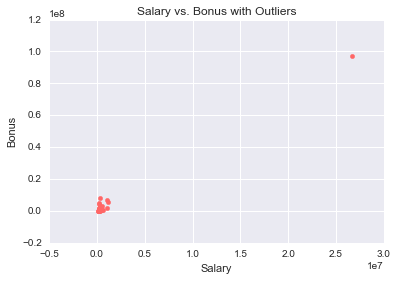

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
visualise_features("salary", "bonus", "Salary vs. Bonus with Outliers")

In [9]:
for employee, features in data_dict.iteritems():
    if not (features['salary'] == 'NaN') and features['salary'] > 2000000:
            print employee, features['salary']

TOTAL 26704229


After inspecting closely what this outlier might be I figured out that it is the "TOTAL" row from the parsed pdf. That is obviously an error during parsing of the data so it must be removed. There was also another outlier. This time it wasn't an extreme value however in the context of our POI identifier it wasn't needed as it wasn't a person. It was the entry for "THE TRAVEL AGENCY IN THE PARK" which was removed as well.

In [10]:
data_dict.pop("TOTAL")
data_dict.pop("THE TRAVEL AGENCY IN THE PARK")

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

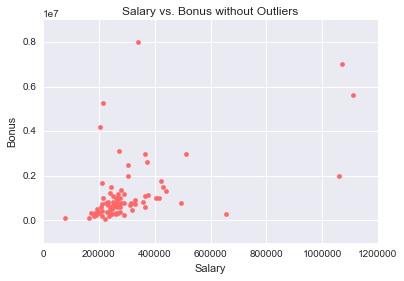

In [11]:
visualise_features("salary", "bonus", "Salary vs. Bonus without Outliers")

## III. Creating New Features

Next up three new features were created. One called "fraction_from_poi" which is the fraction of email messages received from a poi to all the messages received and "fraction_to_poi" which is the fraction of email messages sent to a poi to all the messages sent by a given person. My logic states that if a given person has a lot of interaction with a POI then he might be a POI as well so the fraction of messages to and from a POI were computed and used as a feature in the algorithms to follow. And the last feature I want to add is bonus_salary_ratio which combine the effect of bonus and salary as descibed by the above scatterplot.



In [12]:

### Task 3: Create new feature(s)
# Bonus-salary ratio
for employee, features in data_dict.iteritems():
    if features['bonus'] == "NaN" or features['salary'] == "NaN":
        features['bonus_salary_ratio'] = "NaN"
    else:
        features['bonus_salary_ratio'] = float(features['bonus']) / float(features['salary'])

# from_this_person_to_poi as a percentage of from_messages
for employee, features in data_dict.iteritems():
    if features['from_this_person_to_poi'] == "NaN" or features['from_messages'] == "NaN":
        features['fraction_to_poi'] = "NaN"
    else:
        features['fraction_to_poi'] = float(features['from_this_person_to_poi']) / float(features['from_messages'])

# from_poi_to_this_person as a percentage of to_messages
for employee, features in data_dict.iteritems():
    if features['from_poi_to_this_person'] == "NaN" or features['to_messages'] == "NaN":
        features['fraction_from_poi'] = "NaN"
    else:
        features['fraction_from_poi'] = float(features['from_poi_to_this_person']) / float(features['to_messages'])

### Store to my_dataset for easy export below.

my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


Here is the visualisation of those two features. 

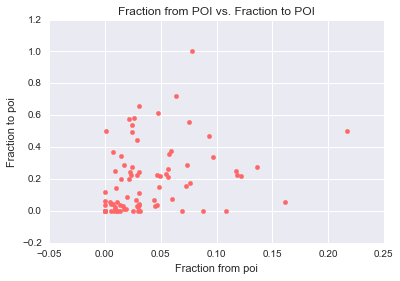

In [13]:
visualise_features("fraction_from_poi", "fraction_to_poi", "Fraction from POI vs. Fraction to POI")

## IV. Algorithm Implementation

In [30]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

skb = SelectKBest(f_classif)

nb = GaussianNB()

dt = DecisionTreeClassifier()

rf = RandomForestClassifier()

pca = PCA()

pipeline1 = Pipeline([("kbest", skb), ("nb", nb )])

pipeline2 = Pipeline([("kbest", skb), ("dt", dt )])

pipeline3 = Pipeline([("kbest", skb), ("rf", rf )])

pipeline4 = Pipeline([("kbest", skb), ("PCA", pca ),("dt", dt )])

params1 = {"kbest__k": range(5, 10)}

params2 = {"kbest__k": range(5, 10),
           "dt__min_samples_split": [2, 4, 6],
           "dt__min_samples_leaf": [2, 4, 6],
           "dt__criterion": ["gini", "entropy"]}

params3 = {"kbest__k": range(5, 10),
           "rf__max_depth": [None, 5, 10],
           "rf__n_estimators": [10, 15, 20]}

params4 = {"kbest__k": range(5, 10),
           "PCA__whiten": [True, False],
           "dt__min_samples_split": [2, 4, 6],
           "dt__min_samples_leaf": [2, 4, 6],
           "dt__criterion": ["gini", "entropy"]}


## V. Data Set Split and Validation

Validation is the process of holding out a part of your dataset in order to have a training and a testing dataset in which later you will test your algorithm and validate it's performance. Some of the benefits of validation and splitting our dataset is that it gives as an estimate of the performance of our algorithm in an independent dataset and also it serves as a check on overfitting. If not done one of the classic results is an overfit classifier which won't be able to classify new, unknown data correctly.
Because our data set is imbalanced a suitable method for splitting it is using Stratified Shuffle Split which creates many folds of different splits of the data set each time and uses them to validate our algorithm.

100 folds were found to be suitable because a bigger number would increase execution time a lot.

In [16]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

sss = StratifiedShuffleSplit(labels, 100, test_size=0.3, random_state=60)

## VI. Algorithm choice and tuning

### a) K Best + Naive Bayes

Initially I decided to try Naive Bayes for this particular classification problem and in particular GaussianNB. Also, GridSearchCV was used for parameter tuning for both Naive Bayes (which doesn't need tuning though) and the final algorithm that was chosen. Tuning an algorithm which supports parameter tuning is important because each algorithm can't give us the best results available by using its default parameters. In order however to avoid tuning them manually GridSearchCV provides an easy and helpful way to do this automatically and get the best parameters for a given algorithm.

In [20]:
gs = GridSearchCV(pipeline1, params1, n_jobs=-1, cv=sss)
gs.fit(features, labels)

clf = gs.best_estimator_

from tester import test_classifier

print "Tester Classification report"
test_classifier(clf.named_steps["nb"], data_dict, features_list)

features_used = gs.best_estimator_.named_steps["kbest"].get_support(indices=True)
print "A total of %d features were used" % len(features_used)
#Note 1: You use 'features_list[i+1]', instead of 'features_list[i]', 
#because the first feature in that list is 'poi' 
#which you didn't include in the variable 'features'
feature_names = [features_list[i + 1] for i in features_used]
print "The features used are:", feature_names

Tester Classification report
GaussianNB(priors=None)
	Accuracy: 0.73893	Precision: 0.22582	Recall: 0.39450	F1: 0.28722	F2: 0.34322
	Total predictions: 15000	True positives:  789	False positives: 2705	False negatives: 1211	True negatives: 10295

A total of 7 features were used
The features used are: ['salary', 'bonus_salary_ratio', 'fraction_to_poi', 'bonus', 'deferred_income', 'total_stock_value', 'exercised_stock_options']


The evaluation metrics of choice was the f1 score which is a weighted average of precision and recall. Precision is the fraction of true positives to all the data points marked as positive and recall is the fraction of true positives to all the positives available. Precision is a measure of exactness and precision is a measure of completeness.

In the context of this POI identifier high precision means that someone identified as a POI is indeed a POI and high recall means that if a POI shows up the identifier will identify him/her at the cost of having someone non-POI being identified as a POI as well.

However there was a really low precision and recall score with GaussianNB so the next choice to try was Decision Trees. Specifically the test_classifier function was used which was provided by Udacity to evaluate the classifier.

Due to having set up a pipeline with KBest in it some extra measures had to be taken to identify how many and which features it decided to use.

It turns out that it used 7 features and they were salary, fraction_to_poi, bonus, deferred_income, total_stock_value, exercised_stock_options and long_term_incentive.

### b) K-Best + Decision Tree:

In [25]:
gs = GridSearchCV(pipeline2, params2, n_jobs=-1, cv=sss, scoring="f1")
gs.fit(features, labels)
clf= gs.best_estimator_
print "Tester Classification report"
test_classifier(clf.named_steps["dt"], data_dict, features_list)

features_used = gs.best_estimator_.named_steps["kbest"].get_support(indices=True)
print "A total of %d features were used" % len(features_used)
#Note 1: You use 'features_list[i+1]', instead of 'features_list[i]', 
#because the first feature in that list is 'poi' 
#which you didn't include in the variable 'features'
feature_names = [features_list[i + 1] for i in features_used]
#print "The features used are:", feature_names
scores = [clf.named_steps['kbest'].scores_[i + 1] for i in features_used]
#print 'Scores: ', scores
importances = [clf.named_steps['dt'].feature_importances_[i+1] for i in features_used]
#print 'Importance: ', importances
import numpy as np
indices = np.argsort(importances)[::-1]
#print 'Indices: ', indices
for i in range(len(feature_names)):
    print "feature no. {}: {} ({}) ({})".format(i+1, feature_names[indices[i]], importances[indices[i]], scores[indices[i]])


Tester Classification report
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.86300	Precision: 0.47909	Recall: 0.31500	F1: 0.38009	F2: 0.33816
	Total predictions: 15000	True positives:  630	False positives:  685	False negatives: 1370	True negatives: 12315

A total of 8 features were used
feature no. 1: total_stock_value (0.415248411841) (6.09417331064)
feature no. 2: exercised_stock_options (0.242096186477) (4.187477507)
feature no. 3: long_term_incentive (0.0) (9.21281062198)
feature no. 4: deferred_income (0.0) (24.1828986786)
feature no. 5: bonus (0.0) (0.0654996529099)
feature no. 6: fraction_to_poi (0.0) (0.224611274736)
feature no. 7: bonus_salary_ratio (0.0) (3.12809174816)
feature no. 8: salary (0.0) (10

### c) K-Best + PCA + Decision Tree:

In [31]:
gs = GridSearchCV(pipeline4, params4, n_jobs=-1, cv=sss, scoring="f1")
gs.fit(features, labels)
clf= gs.best_estimator_
print "Tester Classification report"
test_classifier(clf.named_steps["dt"], data_dict, features_list)

features_used = gs.best_estimator_.named_steps["kbest"].get_support(indices=True)
print "A total of %d features were used" % len(features_used)
#Note 1: You use 'features_list[i+1]', instead of 'features_list[i]', 
#because the first feature in that list is 'poi' 
#which you didn't include in the variable 'features'
feature_names = [features_list[i + 1] for i in features_used]
#print "The features used are:", feature_names
scores = [clf.named_steps['kbest'].scores_[i + 1] for i in features_used]
#print 'Scores: ', scores
importances = [clf.named_steps['dt'].feature_importances_[i+1] for i in features_used]
#print 'Importance: ', importances
import numpy as np
indices = np.argsort(importances)[::-1]
#print 'Indices: ', indices
for i in range(len(feature_names)):
    print "feature no. {}: {} ({}) ({})".format(i+1, feature_names[indices[i]], importances[indices[i]], scores[indices[i]])


Tester Classification report
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
	Accuracy: 0.83573	Precision: 0.34896	Recall: 0.26800	F1: 0.30317	F2: 0.28104
	Total predictions: 15000	True positives:  536	False positives: 1000	False negatives: 1464	True negatives: 12000

A total of 8 features were used
feature no. 1: total_stock_value (0.148423005566) (6.09417331064)
feature no. 2: long_term_incentive (0.0398291925466) (9.21281062198)
feature no. 3: deferred_income (0.0362637362637) (24.1828986786)
feature no. 4: exercised_stock_options (0.0) (4.187477507)
feature no. 5: bonus (0.0) (0.0654996529099)
feature no. 6: fraction_to_poi (0.0) (0.224611274736)
feature no. 7: bonus_salary_ratio (0.0) (3.12809174816)
feature no. 8: salary

### d) K-Best + Random Forest:

In [27]:
gs = GridSearchCV(pipeline3, params3, n_jobs=-1, cv=sss, scoring="f1")
gs.fit(features, labels)
clf= gs.best_estimator_
print "Tester Classification report"
test_classifier(clf.named_steps["rf"], data_dict, features_list)

features_used = gs.best_estimator_.named_steps["kbest"].get_support(indices=True)
print "A total of %d features were used" % len(features_used)
#Note 1: You use 'features_list[i+1]', instead of 'features_list[i]', 
#because the first feature in that list is 'poi' 
#which you didn't include in the variable 'features'
feature_names = [features_list[i + 1] for i in features_used]
#print "The features used are:", feature_names
scores = [clf.named_steps['kbest'].scores_[i + 1] for i in features_used]
#print 'Scores: ', scores
importances = [clf.named_steps['rf'].feature_importances_[i+1] for i in features_used]
#print 'Importance: ', importances
indices = np.argsort(importances)[::-1]
#print 'Indices: ', indices
for i in range(len(feature_names)):
    print "feature no. {}: {} ({}) ({})".format(i+1, feature_names[indices[i]], importances[indices[i]], scores[indices[i]])


Tester Classification report
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
	Accuracy: 0.85900	Precision: 0.41913	Recall: 0.14900	F1: 0.21985	F2: 0.17105
	Total predictions: 15000	True positives:  298	False positives:  413	False negatives: 1702	True negatives: 12587

A total of 7 features were used
feature no. 1: exercised_stock_options (0.131807072432) (4.187477507)
feature no. 2: salary (0.108060685836) (10.7835847082)
feature no. 3: deferred_income (0.0937505101258) (24.1828986786)
feature no. 4: total_stock_value (0.0792989792216) (6.09417331064)
feature no. 5: bonus_salary_ratio (0.0362388786902) (3.12809174816)
feature no. 6: fraction_to_poi (0.01072258

In [ ]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf1, data_dict, features_list)
dump_classifier_and_data(clf2, data_dict, features_list)

In [ ]:
dump_classifier_and_data(clf2, data_dict, features_list)